## Todo

- try converting these to .tocsr().tocoo()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scanpy as sc
import os
remote_atac_dir = '/om2/user/rogerjin/data/NeurIPS2021/multiome/atac'
remote_rna_dir = '/om2/user/rogerjin/data/NeurIPS2021/multiome/rna'
os.makedirs(remote_rna_dir, exist_ok=True)
remote_atac_path = '/om2/user/rogerjin/data/NeurIPS2021/multiome/multiome_atac_processed_training.h5ad'
remote_rna_path = '/om2/user/rogerjin/data/NeurIPS2021/multiome/multiome_gex_processed_training.h5ad'

In [70]:
atac = sc.read_h5ad(remote_atac_path)
rna = sc.read_h5ad(remote_rna_path)
display(atac)
display(rna)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
atac_train, atac_val_test, rna_train, rna_val_test = train_test_split(atac, rna, test_size=0.2, random_state=42)
atac_val, atac_test, rna_val, rna_test = train_test_split(atac_val_test, rna_val_test, test_size=0.5, random_state=75)

In [76]:
atac_split = {
    'train': atac_train,
    'val': atac_val,
    'test': atac_test
}

rna_split = {
    'train': rna_train,
    'val': rna_val,
    'test': rna_test
}

In [77]:
for split_name, split in atac_split.items():
    split.write_h5ad(f'{remote_atac_dir}/atac_{split_name}.h5ad')
    
for split_name, split in rna_split.items():
    split.write_h5ad(f'{remote_rna_dir}/rna_{split_name}.h5ad')

In [2]:
atac_split = {
    'train': sc.read_h5ad(f'{remote_atac_dir}/atac_train.h5ad'),
    'val': sc.read_h5ad(f'{remote_atac_dir}/atac_val.h5ad'),
    'test': sc.read_h5ad(f'{remote_atac_dir}/atac_test.h5ad')
}

In [3]:
def var(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    source: https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

var_atac_train = var(atac_split['train'].X, axis=0)
var_atac_train

matrix([[0.00756116, 0.00857404, 0.01617414, ..., 0.00712643, 0.14550444,
         0.01257566]])

In [4]:
sorted_indices = np.fliplr(var_atac_train.argsort())
sorted_indices = np.asarray(sorted_indices).squeeze()
display(var_atac_train[:, sorted_indices])

matrix([[0.24999275, 0.24982592, 0.24817671, ..., 0.0014394 , 0.00141006,
         0.00138073]])

In [5]:
torch.save(torch.tensor(sorted_indices.copy()), f'{remote_atac_dir}/sorted_indices_decreasing_variance.pt')

In [6]:
for split_name, split in atac_split.items():
    split[:, sorted_indices].write_h5ad(f'{remote_atac_dir}/atac_{split_name}_sorted_decreasing_variance.h5ad')

In [8]:
top_512 = sorted_indices.tolist()[:512]

Not sure if this inbalance matters or not.

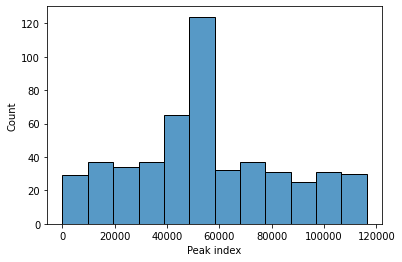

In [15]:
import seaborn as sns

ax = sns.histplot(top_512)
_ = ax.set(xlabel='Peak index')

## Training

In [3]:
import wandb

config = {
    'batch_size': 8,
    'lr': 5e-4,
}

wandb.init(project="Squish Transformer", entity="rogershijin", reinit=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rogershijin. Use `wandb login --relogin` to force relogin


In [4]:
import scanpy as sc

atac = {
    'train': sc.read_h5ad(f'{remote_atac_dir}/atac_train_sorted_decreasing_variance.h5ad'),
    'val': sc.read_h5ad(f'{remote_atac_dir}/atac_val_sorted_decreasing_variance.h5ad'),
    'test': sc.read_h5ad(f'{remote_atac_dir}/atac_test_sorted_decreasing_variance.h5ad')
}

rna = {
    'train': sc.read_h5ad(f'{remote_rna_dir}/rna_train.h5ad'),
    'val': sc.read_h5ad(f'{remote_rna_dir}/rna_val.h5ad'),
    'test': sc.read_h5ad(f'{remote_rna_dir}/rna_test.h5ad')
}

In [5]:
from ganoli.GanoliDataset import GanoliMultimodalDataset
from muon import MuData

class MuDataWithLen(MuData):
    
    def __len__(self):
        try:
            return self._len
        except:
            self._len = min(len(mod) for mod in self.mod.values())
            return self._len

datasets = {
    partition: MuDataWithLen({'atac': atac[partition], 'rna': rna[partition]}) for partition in atac.keys()
}
datasets

{'train': MuData object with n_obs × n_vars = 33993 × 129921
   var:	'feature_types'
   2 modalities
     atac:	33993 x 116490
       obs:	'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
       var:	'feature_types'
       uns:	'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
       obsm:	'gene_activity', 'lsi_full', 'lsi_red', 'umap'
       layers:	'counts'
     rna:	33993 x 13431
       obs:	'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch', 'pseudotime_order_ATAC', 'is_train'
       var:	'gene_ids', 'feature_types', 'genome'
       uns:	'dataset_id', 'organism'
       obsm:	'X_pca', 'X_umap'
       layers:	'counts',
 'val': MuData object with n_obs × n_vars = 4249 × 129921
   var:	'feature_types'
   2 modalities
     atac:	4249 x 116490
       obs:	'nCount_peaks', 'ata

In [33]:
from muon import MuData as md
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler
torch.manual_seed(42)

BATCH_SIZE = 1

samplers = {
    'train': RandomSampler,
    'val': SequentialSampler,
    'test': SequentialSampler
}

loaders = {
    partition: DataLoader(dataset, sampler=BatchSampler(samplers[partition](dataset), batch_size=BATCH_SIZE, drop_last=False ), collate_fn=lambda x: x[0]) for partition, dataset in datasets.items()
}

In [7]:
LOCAL = False
cache_dir=None if LOCAL else "/om2/user/rogerjin/.cache"
print("local" if LOCAL else "remote")

remote


In [37]:
try:
    del model
except:
    pass
try:
    del squished
except:
    pass
try:
    del rna
except:
    pass
torch.cuda.empty_cache()

In [58]:
from transformers import DistilBertModel, DistilBertConfig
from torch.nn import Linear

class SquishTransformer(torch.nn.Module):
    
    def __init__(self, output_dim=13431):
        super().__init__()
        self.output_dim = output_dim
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', cache_dir=cache_dir)
        self.distilbert.embeddings.word_embeddings = torch.nn.Embedding(116491, 768) # todo: magic numbers
        self.pre_classifier = Linear(self.distilbert.config.dim, self.distilbert.config.dim)
        self.classifier = Linear(self.distilbert.config.dim, output_dim)
        
    def forward(self, **kwargs):
        out = self.distilbert(**kwargs).last_hidden_state[:, 0] # embedding of cls
        out = self.pre_classifier(out)
        out = self.classifier(out)
        return out

model = SquishTransformer()
# device = 'cpu'
device = 'cuda:0'
_ = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
from squish_indexing import squish_and_embed
from torch.nn import MSELoss
from torch.optim import Adam

EPOCHS = 2

device = 'cuda:0'
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)

for epoch in range(EPOCHS):
    total_loss = 0
    for batch in loaders['train']:
        optimizer.zero_grad()
        atac = batch.mod['atac'].layers['counts'].tocsr().tocoo()
        squished = squish_and_embed(atac, model.distilbert.embeddings.word_embeddings)
        rna = torch.tensor(batch.mod['rna'].X.todense()).float().to(device)
        out = model(inputs_embeds=squished['embeddings'], attention_mask=squished['attention_mask'])
        loss = loss_fn(out, rna)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'END OF EPOCH {epoch+1}')
    print(f'Loss={total_loss}')

forout torch.Size([1, 768])
END OF EPOCH 1
Loss=0.17400246858596802


RuntimeError: CUDA out of memory. Tried to allocate 3.68 GiB (GPU 0; 79.35 GiB total capacity; 71.24 GiB already allocated; 259.19 MiB free; 77.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [48]:
A = [1,2,3,4]
t = torch.tensor(A)
t

tensor([1, 2, 3, 4])

In [13]:
import sys
sys.executable

'/om2/user/rogerjin/conda/ganoli/bin/python'